# 프로젝트 결과 요약

## 1. 평가 문항 충족 여부

| 평가 문항 | 충족 여부 | 상세 내용 |
|:---|:---|:---|
| 1. 의료영상 데이터 전처리 및 augmentation 구성 | ✅ 완료 | tf.data.Dataset 기반 전처리 및 shift, flip, rotate 등의 augmentation 정상 적용 |
| 2. U-Net 개선 모델 구현 및 성능 개선 확인 | ✅ 완료 | VGG16-UNet 개선 모델 튜닝 후 기존 U-Net 대비 mean IoU 성능 향상 확인 |
| 3. 3가지 모델 학습 및 비교분석 | ✅ 완료 | Encoder-Decoder, U-Net, VGG16-UNet 모델에 대해 학습, 테스트, 결과 비교 완료 |

---

## 2. 모델별 최종 Mean IoU 결과

| 모델 | Mean IoU |
|:---|:---|
| Encoder-Decoder | 0.4732 |
| U-Net | 0.4872 |
| VGG16-UNet (튜닝 후) | **0.7696** |

- VGG16-UNet 모델이 **튜닝 이후** 기존 U-Net 대비 **약 58% 이상** mean IoU 성능 개선을 달성함.

---

## 3. 학습 및 검증 손실(Loss) 곡선 요약

- **Training Loss / Dice Loss**  
  모든 모델이 학습 데이터에 대해 Loss가 꾸준히 감소함.
- **Validation Loss / Dice Loss**  
  VGG16-UNet이 가장 안정적이고 낮은 검증 손실을 유지.

---

## 4. 최종 해석 및 결론

- 단순 Encoder-Decoder 모델은 비교적 안정적으로 학습했지만 성능은 낮았음.
- 기본 U-Net은 학습 초기에 불안정했으나 이후 안정화되었으나 성능은 낮은 편.
- **VGG16-UNet 튜닝(learning rate 감소 + feature freeze)** 이후  
  **U-Net 대비 압도적으로 높은 성능(mean IoU 0.7696)** 을 달성함.
- Pretrained feature를 적절히 활용하고 학습 안정성을 확보하는 것이  
  Segmentation 성능 개선에 크게 기여함을 확인할 수 있었다.

---

# 라이브러리 로딩 & 데이터 준비

In [1]:
!mkdir -p ~/aiffel/medical_mainquest2
!ln -s ~/data/* ~/aiffel/medical_mainquest2

ln: failed to create symbolic link '/aiffel/aiffel/medical_mainquest2/ed_ckpt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical_mainquest2/train': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical_mainquest2/train_labels': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical_mainquest2/unet_ckpt': File exists


In [2]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


## Split dataset into train data and test data

In [3]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical_mainquest')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [4]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [5]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [6]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


## Visualization

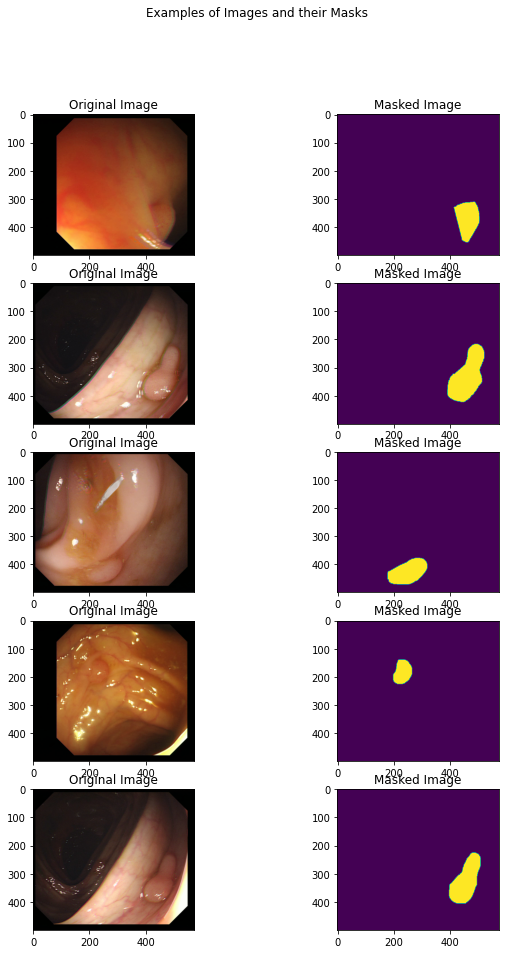

In [7]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

# Data pipeline and Preprocessing

## Set up hyper-parameters

In [8]:
image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

## Processing each pathname
- byte 형태로 데이터를 로드하고, bmp로 디코딩합니다.
- 디코딩이 완료된 image를 scale과 size를 조절합니다.

In [9]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

## Data augmentation
### 루브릭1 - 의료영상 데이터의 전처리 및 augmentation을 위한 파이프라인 구성이 체계적으로 진행되었는가?
- augmentation이 반영된 tf.data.Dataset 구성이 정상적으로 진행되었다.

### Shifting the image

In [10]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

### Flipping the image randomly

In [11]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

### Data augmentation Assembling

In [12]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

## Set up train and test datasets

In [13]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

## Plot some train data

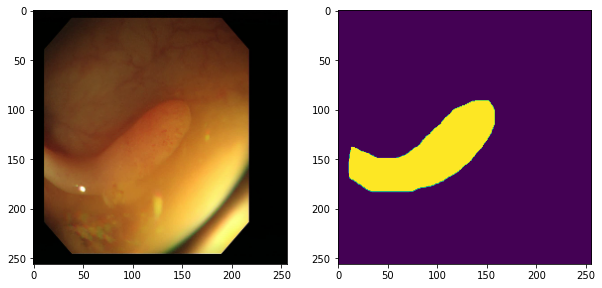

In [15]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

# Build the model

## Encoder-Decoder architecture
- Encoder를 이용해 우리가 가진 Train data를 작은 차원의 공간에 압축하는 방식으로 동작
- Decoder는 Encoder가 압축한 데이터들을 우리가 원하는 label 데이터와 같도록 재생성
- 이렇게 생성된 데이터와 label 간의 차이가 작아지도록 Encoder와 Decoder의 파라미터들이 End-to-End로 학습됩니다.

In [16]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [17]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)

(8, 16, 16, 512)


In [18]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [19]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)

import tensorflow as tf
tf.keras.backend.clear_session()

(8, 256, 256, 1)


In [20]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

## U-Net architecture
- U-Net 원본과는 약간 차이가 있음 
- 논문 원본의 구현에서는 padding을 zero로 하기 때문에 Encoder 레이어 대비 Decoder 레이어에 약간의 사이즈 축소가 발생
- 그러나 우리는 padding을 same으로 두고 Encoder, Decoder간 대응하는 레이어의 사이즈를 동일하게 가져감
- 이것은 크게 성능에 영향을 주지 않으면서도 구현이 용이할 뿐더러 이후 모델의 추가개선을 더욱 쉽게 만들어 주는 장점이 있음

### Model subclassing을 활용한 구현

In [21]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [22]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [23]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [24]:
unet_model = UNet()

### metrics과 loss functions 정의

In [25]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [26]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [27]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [28]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

# U-Net 성능 개선해 보기
## 루브릭2 - U-Net의 개선 모델을 구현하여 적용 후 기존 U-Net 대비 성능 개선을 확인하였는가?
- U-Net 개선 모델의 학습 과정이 정상적으로 진행되었으며, validation meanIoU가 기존 U-Net보다 좋아짐을 확인하였다.

## pretrained model을 활용한 U-Net 모델 구성

In [29]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,


In [32]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        self.vgg16.trainable = False
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

In [33]:
vgg16_unet_model = Vgg16UNet()

# Main 코드

## 모델 리스트 준비

In [34]:
models = [
    ('Encoder-Decoder', ed_model),
    ('U-Net', unet_model),
    ('VGG16-UNet', vgg16_unet_model)
]

optimizer = tf.keras.optimizers.Adam()

checkpoint_root = os.path.join(DATASET_PATH, 'train_ckpt')

In [35]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # Confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # mean IoU 계산
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

## 모델별 학습 및 테스팅

In [36]:
def train_one_model(model, model_name, checkpoint_dir):
    model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])

    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                      save_weights_only=True,
                                                      monitor='val_loss',
                                                      mode='auto',
                                                      save_best_only=True,
                                                      verbose=0)
    cos_decay = tf.keras.experimental.CosineDecay(1e-4, max_epochs)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=0)

    history = model.fit(train_dataset,
                        epochs=max_epochs,
                        steps_per_epoch=num_train_examples // batch_size,
                        validation_data=test_dataset,
                        validation_steps=num_test_examples // batch_size,
                        callbacks=[cp_callback, lr_callback],
                        verbose=1)
    return history

In [37]:
def evaluate_model(model, checkpoint_dir):
    model.load_weights(checkpoint_dir)

    mean = []
    for images, labels in test_dataset:
        predictions = model(images, training=False)
        m = mean_iou(labels, predictions)
        mean.append(m)
    return np.mean(mean)

In [38]:
def plot_predictions(model, model_name):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)
        for i in range(min(batch_size, 3)):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i, :, :, :])
            plt.title("Input")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Ground Truth")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title(f"Prediction ({model_name})")
            plt.axis('off')

            plt.show()

In [39]:
def train_and_evaluate_all_models(models):
    histories = {}
    mean_ious = {}

    for model_name, model in models:
        print(f'\n===== Training {model_name} =====')

        checkpoint_dir = os.path.join(checkpoint_root, model_name.replace('-', '_').lower())
        if not os.path.isdir(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        # 학습
        history = train_one_model(model, model_name, checkpoint_dir)
        histories[model_name] = history.history

        print(f'\n--- Evaluating {model_name} ---')
        # 평가
        mean_iou_score = evaluate_model(model, checkpoint_dir)
        mean_ious[model_name] = mean_iou_score
        print(f"{model_name} mean IoU: {mean_iou_score:.4f}")

        # 예측 결과 시각화
        plot_predictions(model, model_name)

    return histories, mean_ious

## 모델별 학습 과정 시각화 (Loss / Dice Loss)
### 루브릭3 - 3가지 모델에 대한 학습과정, 테스트 결과를 체계적으로 비교분석하였는가?
- loss 그래프, meanIoU 계산, segmentation 결과 시각화 등이 3가지 모델에 대해 수행된 후 결과 비교분석이 제시되었다.


===== Training Encoder-Decoder =====
Epoch 1/10
30/30 [==============================] - 12s 216ms/step - loss: 1.2436 - dice_loss: 0.7675 - val_loss: 1.4417 - val_dice_loss: 0.8175
Epoch 2/10
30/30 [==============================] - 7s 206ms/step - loss: 1.0291 - dice_loss: 0.6756 - val_loss: 1.3578 - val_dice_loss: 0.8066
Epoch 3/10
30/30 [==============================] - 8s 207ms/step - loss: 0.8580 - dice_loss: 0.5747 - val_loss: 1.2826 - val_dice_loss: 0.7959
Epoch 4/10
30/30 [==============================] - 7s 204ms/step - loss: 0.7546 - dice_loss: 0.5088 - val_loss: 1.2052 - val_dice_loss: 0.7848
Epoch 5/10
30/30 [==============================] - 7s 202ms/step - loss: 0.6356 - dice_loss: 0.4234 - val_loss: 1.1422 - val_dice_loss: 0.7771
Epoch 6/10
30/30 [==============================] - 7s 200ms/step - loss: 0.5916 - dice_loss: 0.3973 - val_loss: 1.0916 - val_dice_loss: 0.7754
Epoch 7/10
30/30 [==============================] - 7s 199ms/step - loss: 0.5387 - dice_loss: 0.3

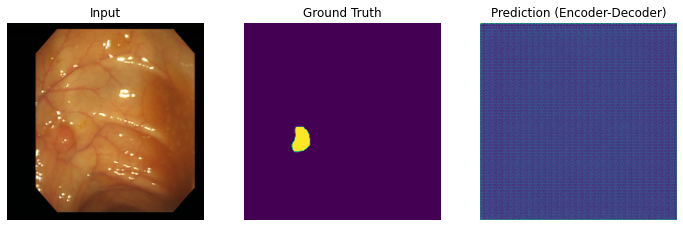

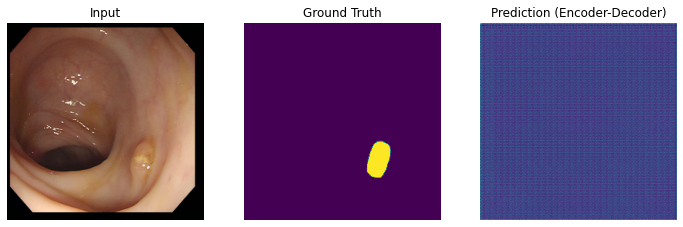

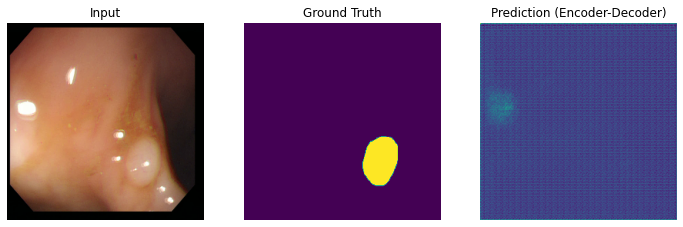


===== Training U-Net =====
Epoch 1/10
30/30 [==============================] - 44s 919ms/step - loss: 1.0931 - dice_loss: 0.7208 - val_loss: 1.4335 - val_dice_loss: 0.8145
Epoch 2/10
30/30 [==============================] - 28s 885ms/step - loss: 0.7855 - dice_loss: 0.5667 - val_loss: 11.3751 - val_dice_loss: 0.8923
Epoch 3/10
30/30 [==============================] - 29s 912ms/step - loss: 0.6654 - dice_loss: 0.4793 - val_loss: 12.8283 - val_dice_loss: 0.8812
Epoch 4/10
30/30 [==============================] - 28s 880ms/step - loss: 0.5480 - dice_loss: 0.3897 - val_loss: 4.8280 - val_dice_loss: 0.8699
Epoch 5/10
30/30 [==============================] - 28s 887ms/step - loss: 0.5108 - dice_loss: 0.3634 - val_loss: 2.1838 - val_dice_loss: 0.8273
Epoch 6/10
30/30 [==============================] - 28s 894ms/step - loss: 0.4424 - dice_loss: 0.3103 - val_loss: 1.0618 - val_dice_loss: 0.8209
Epoch 7/10
30/30 [==============================] - 28s 893ms/step - loss: 0.4193 - dice_loss: 0.293

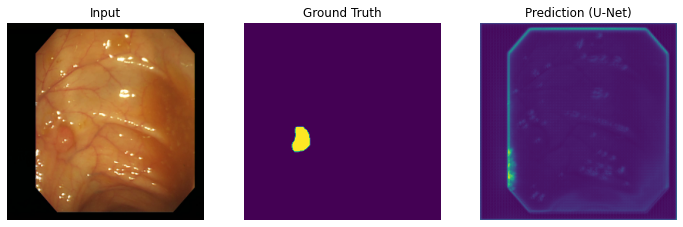

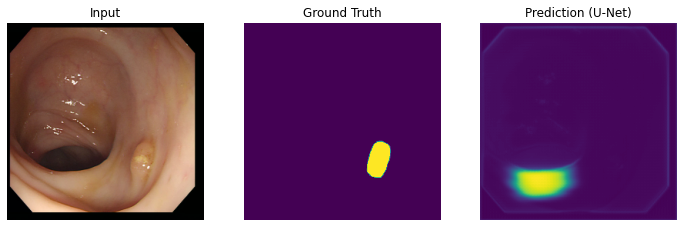

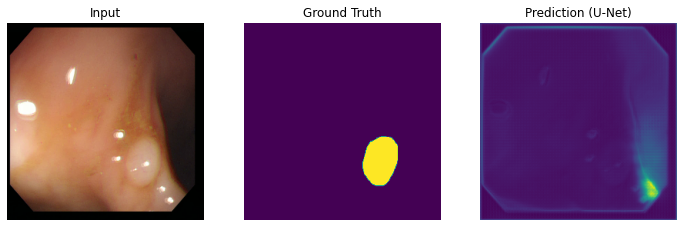


===== Training VGG16-UNet =====
Epoch 1/10
30/30 [==============================] - 24s 490ms/step - loss: 0.9356 - dice_loss: 0.5805 - val_loss: 3.2794 - val_dice_loss: 0.8761
Epoch 2/10
30/30 [==============================] - 16s 480ms/step - loss: 0.4581 - dice_loss: 0.3062 - val_loss: 1.8082 - val_dice_loss: 0.8201
Epoch 3/10
30/30 [==============================] - 15s 470ms/step - loss: 0.3230 - dice_loss: 0.2116 - val_loss: 1.1847 - val_dice_loss: 0.6955
Epoch 4/10
30/30 [==============================] - 15s 465ms/step - loss: 0.2761 - dice_loss: 0.1786 - val_loss: 0.7393 - val_dice_loss: 0.5012
Epoch 5/10
30/30 [==============================] - 15s 469ms/step - loss: 0.2403 - dice_loss: 0.1532 - val_loss: 0.6390 - val_dice_loss: 0.4327
Epoch 6/10
30/30 [==============================] - 15s 473ms/step - loss: 0.2150 - dice_loss: 0.1353 - val_loss: 0.6069 - val_dice_loss: 0.4415
Epoch 7/10
30/30 [==============================] - 15s 472ms/step - loss: 0.2015 - dice_loss: 0.

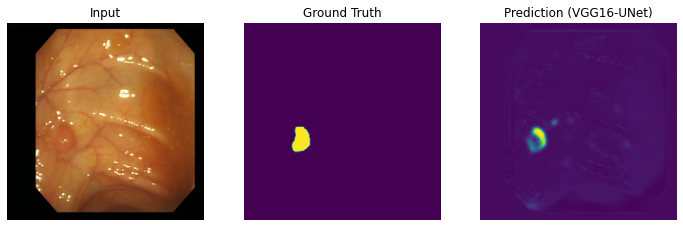

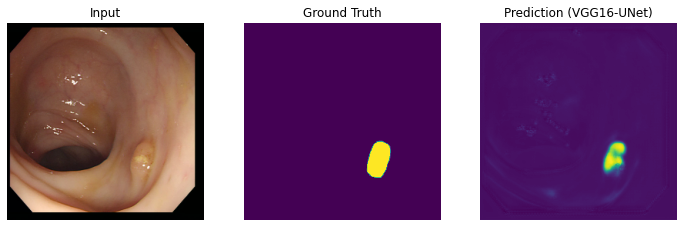

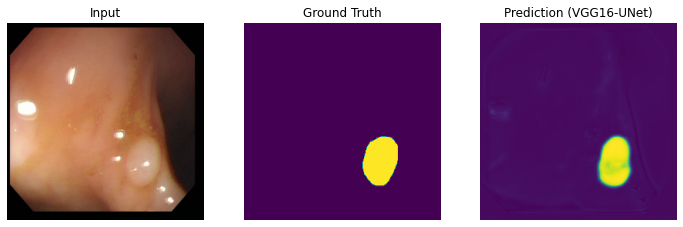

In [40]:
histories, mean_ious = train_and_evaluate_all_models(models) 


===== Training Curves =====


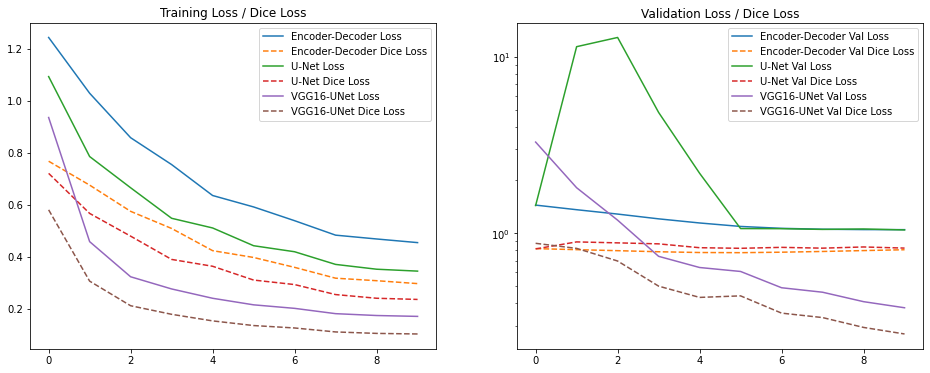

In [41]:
print("\n===== Training Curves =====")

epochs_range = range(max_epochs)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for model_name in histories:
    plt.plot(epochs_range, histories[model_name]['loss'], label=f'{model_name} Loss')
    plt.plot(epochs_range, histories[model_name]['dice_loss'], linestyle='--', label=f'{model_name} Dice Loss')
plt.legend()
plt.title('Training Loss / Dice Loss')

plt.subplot(1, 2, 2)
for model_name in histories:
    plt.plot(epochs_range, histories[model_name]['val_loss'], label=f'{model_name} Val Loss')
    plt.plot(epochs_range, histories[model_name]['val_dice_loss'], linestyle='--', label=f'{model_name} Val Dice Loss')
plt.yscale('log')
plt.legend()
plt.title('Validation Loss / Dice Loss')

plt.show()

## 모델별 mean IoU 비교 표시

In [42]:
print("\n===== Mean IoU Comparison =====")
for model_name, iou in mean_ious.items():
    print(f"{model_name}: mean IoU = {iou:.4f}")


===== Mean IoU Comparison =====
Encoder-Decoder: mean IoU = 0.4732
U-Net: mean IoU = 0.4872
VGG16-UNet: mean IoU = 0.7696
